<a href="https://colab.research.google.com/github/rahulvigneswaran/colab_collection/blob/main/Transformers_from_Scratch_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resource: https://www.youtube.com/watch?v=U0s0f995w14

Parts of Transformers
- Encoder
  - Embedding
  - Positional Encoding
  - Multi-headed Self-attention
    - Query
    - Key
    - Value
  - Residual + LayerNorm
  - Feed Forward Network
  - Residual + LayerNorm
- Decoder
  - Embedding
  - Positional Encoding
  - Masked Multi-headed self-attention
  - Residual + LayerNorm
  - Encoder-Decoded self-attention
    - Multi-headed self attention
      - Encoder Query
      - Encoder Key
      - Decoder Value
    - Residual + LayerNorm
  - Feed Forward Network
  - Residual + LayerNorm
- Linear Layer
- Softmax







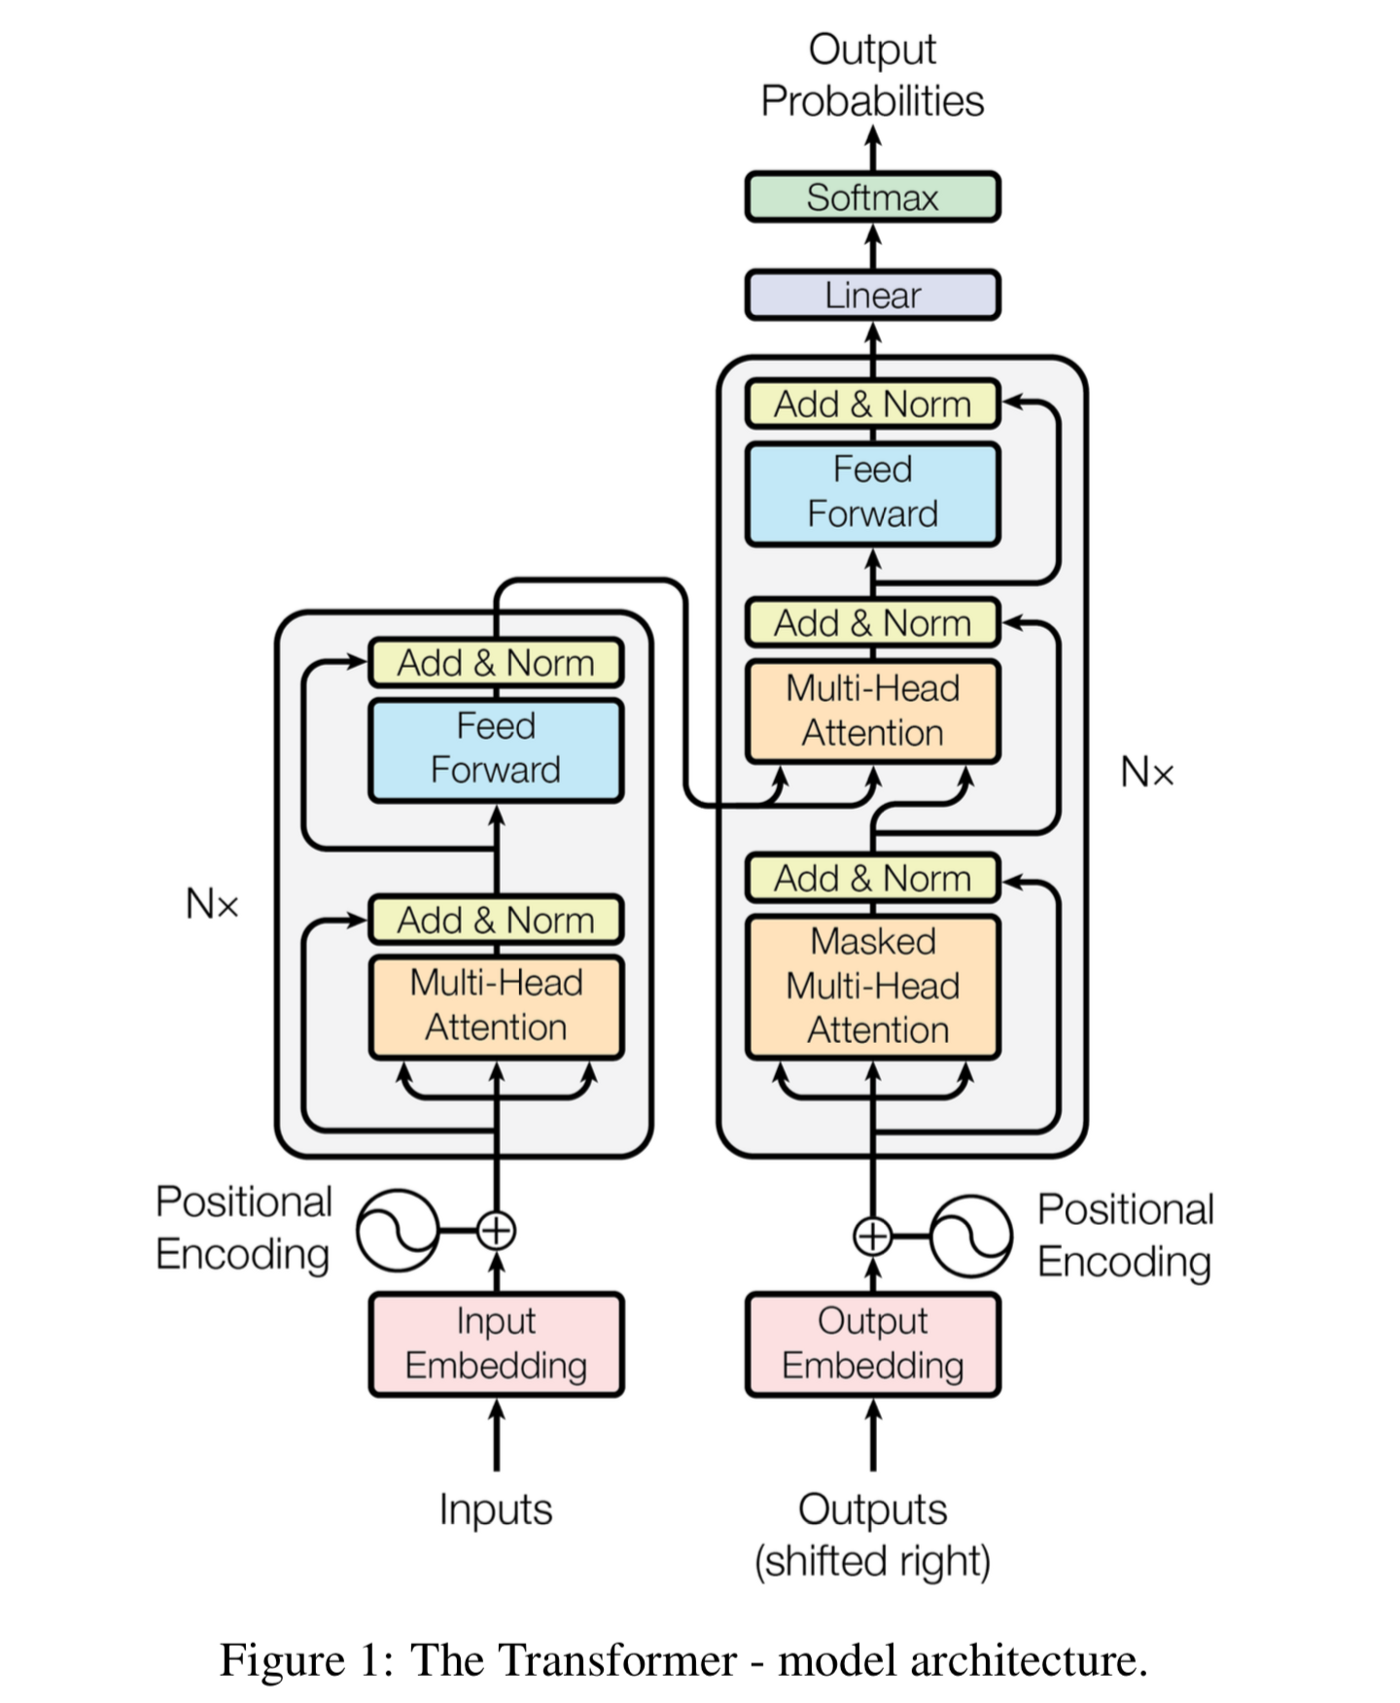

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn

"""
[x] SelfAttention
[x] CommonBlock
[x] Encoder
[x] DecoderBlock
[x] Decoder
[x] Transformer
"""
class SelfAttention (nn.Module):
  """
  1. Takes in (query, key, value, (optionally mask)). 
  2. Splits everything into multiple heads. 
  3. Calculates attention : softmax((Q x K) / d^0.5)
  4. Multiplies attention with values
  5. Pass it through a linear layer

  6. Where are we doing the concatention of different heads? #FIXME

  Notes:
  Query, Key and value are all the same for an encoder. The intuition being that we are getting a dot product between all the queries (nxn vector) (Like cosine distance matrix in retreival tasks).
  Now when we apply softmax over it, we convert these values into probabilities. These probabilities are then used to form a weighted average of the embeddings.
  So essentially, for an encoder we dont need three separate thing called query, key and value. They are the same. Its different story for a decoder though. Here apart from the
  first SelfAttention block, for the rest of the SelfAttention blocks, the query and key are borrowed from the final encoder.

  """
  def __init__(
      self, 
      embed_size=512, 
      heads=1,
      ):
  
    super().__init__()
    self.EMBED_SIZE = embed_size
    self.HEADS = heads
    self.HEAD_DIM = self.EMBED_SIZE // self.HEADS

    assert (self.HEAD_DIM * self.HEADS == self.EMBED_SIZE), "Embed size needs to be div by heads"

    self.query = nn.Linear(self.HEAD_DIM, self.HEAD_DIM, bias=False)
    self.key = nn.Linear(self.HEAD_DIM, self.HEAD_DIM, bias=False)
    self.value = nn.Linear(self.HEAD_DIM, self.HEAD_DIM, bias=False)
    
    self.fc_out = nn.Linear(self.EMBED_SIZE, self.EMBED_SIZE)

  def forward(
      self, 
      query, 
      key, 
      value, 
      mask,
      ):
    
    N = query.shape[0]
    query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

    # Split embeddings for multi-head self-attention
    query = query.reshape(N, query_len, self.HEADS, self.HEAD_DIM)  # Shape: N, query_len, HEADS, HEAD_DIM
    key = key.reshape(N, key_len, self.HEADS, self.HEAD_DIM)           # Shape: N, key_len, HEADS, HEAD_DIM
    value = value.reshape(N, value_len, self.HEADS, self.HEAD_DIM)     # Shape: N, value_len, HEADS, HEAD_DIM

    query = self.query(query)
    key = self.key(key)
    value = self.key(key)

    # query : N, query_len, HEADS, HEAD_DIM
    # key : N, key_len, HEADS, HEAD_DIM
    # energy : N, HEADS, query_len, key_len
    energy = torch.einsum("nqhd, nkhd -> nhqk", [query, key])  # Shape: N, HEADS, queries_len, keys_len

    if mask is not None:
      energy = energy.masked_fill_(mask == 0, float("-1e20"))

    attention = torch.softmax(energy / (self.EMBED_SIZE ** 0.5), dim=3)

    # attention : N, HEADS, queries_len, keys_len
    # values : N, values_len, HEADS, HEAD_DIM
    # out : N, queries_len, HEADS, HEAD_DIM
    out = torch.einsum("nhqk, nvhd -> nqhd", [attention, value]).reshape(N, query_len, self.EMBED_SIZE)

    out = self.fc_out(out)

    return out

class CommonBlock(nn.Module):
  """
  This block is used by both Encoder and Decoder.
  1. Takes in (Query, Key, Value, Mask) tuple.
  2. Does the following in succession
    a. Applies self-attention
    b. Skip connection  (simply add the query before attention to the output from attention)
    c. LayerNorm
    d. Dropout
    e. Feed Forward (Uses FORWARD_EXPANSION to increase the hidden layer neuron count)
    f. Skip connection
    g. LayerNorm
    h. Dropout

  """
  def __init__(
      self, 
      embed_size, 
      heads, 
      dropout, 
      forward_expansion,
      ):
    
    super().__init__()
    self.EMBED_SIZE = embed_size
    self.HEADS = heads
    self.DROPOUT = dropout
    self.FORWARD_EXPANSION = forward_expansion

    # query, key, value, mask -> self.attention -> Skip -> self.norm1 -> self.dropout -> self.feed_forward -> Skip -> self.norm2 -> self.dropout
    self.attention = SelfAttention(self.EMBED_SIZE, self.HEADS)
    self.norm1 = nn.LayerNorm(self.EMBED_SIZE)
    self.norm2 = nn.LayerNorm(self.EMBED_SIZE)
    self.feed_forward = nn.Sequential(
        nn.Linear(self.EMBED_SIZE, self.FORWARD_EXPANSION*self.EMBED_SIZE),
        nn.ReLU(),
        nn.Linear(self.FORWARD_EXPANSION*self.EMBED_SIZE, self.EMBED_SIZE)
    )
    self.dropout = nn.Dropout(self.DROPOUT)

  def forward(
      self, 
      query, 
      key, 
      value, 
      mask,
      ):
    
    """
    query, key, value, mask -> self.attention -> Skip -> self.norm1 -> self.dropout -> self.feed_forward -> Skip -> self.norm2 -> self.dropout
    Not memory efficient but easy to understand
    """
    attention = self.attention(query, key, value, mask) 
    out_attn = self.dropout(self.norm1(attention + query))  # Output from multi-head attention sub-block
    
    feed_forward = self.feed_forward(out_attn)  
    out_ffn = self.dropout(self.norm2(feed_forward + out_attn)) # Output from feed forward network sub-block

    return out_ffn
  
class Encoder(nn.Module):
  """
  1. Takes input
  2. Get word embedding
  3. Gets position of each token in the input (Just start counting from 0). Use that to get positional embedding
  3. Does positional encoding (Add word embedding and positional embedding together)
  4. Dropout
  5. Pass through the common block, num_layers times repeatedly.
  """
  def __init__(
      self, 
      src_vocab_size,
      embed_size, 
      num_layers,
      heads,
      forward_expansion,
      dropout,
      max_length,
      device,
      ):

    super().__init__()
    self.SRC_VOCAB_SIZE = src_vocab_size
    self.EMBED_SIZE = embed_size
    self.NUM_LAYERS = num_layers
    self.HEADS = heads
    self.FORWARD_EXPANSION = forward_expansion
    self.DROPOUT = dropout
    self.MAX_LENGTH = max_length
    self.DEVICE = device
    self.word_embedding = nn.Embedding(self.SRC_VOCAB_SIZE, self.EMBED_SIZE)
    self.positional_embedding = nn.Embedding(self.MAX_LENGTH, self.EMBED_SIZE)

    self.layers = nn.ModuleList(
        [
            CommonBlock(
                embed_size = self.EMBED_SIZE,
                heads = self.HEADS,
                dropout = self.DROPOUT,
                forward_expansion = self.FORWARD_EXPANSION,
            )
            for _ in range(self.NUM_LAYERS)
        ]
    )

    self.dropout = nn.Dropout(self.DROPOUT)

  def forward(
      self, 
      x, 
      mask,
      ):
    N, seq_length = x.shape
    positions = torch.arange(0,seq_length).expand(N, seq_length).to(self.DEVICE)

    out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))

    for layer in self.layers:
      out = layer(out, out, out, mask)
    
    return out

class DecoderBlock(nn.Module):
  """
  CommonBlock+Additional self-attention block
  """
  def __init__(
      self, 
      embed_size,
      heads,
      forward_expansion,
      dropout, 
      device,
      ):
    super().__init__()
    self.EMBED_SIZE = embed_size
    self.HEADS = heads
    self.FORWARD_EXPANSION = forward_expansion
    self.DROPOUT = dropout
    self.DEVICE = device
    self.attention = SelfAttention(
        embed_size= self.EMBED_SIZE,
        heads = self.HEADS,
    )
    self.norm = nn.LayerNorm(self.EMBED_SIZE)
    self.common_block = CommonBlock(
        embed_size = self.EMBED_SIZE,
        heads = self.HEADS,
        dropout = self.DROPOUT,
        forward_expansion = self.FORWARD_EXPANSION,
    )
    self.dropout = nn.Dropout(self.DROPOUT)

  def forward(
      self, 
      x,
      key,
      value,
      src_mask,
      trg_mask,
      ):

    attention = self.attention(x, x, x, trg_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.common_block(query, key, value, src_mask)
    
    return out

class Decoder(nn.Module):
  """
  1. Takes input
  2. Get word embedding
  3. Gets position of each token in the input (Just start counting from 0). Use that to get positional embedding
  3. Does positional encoding (Add word embedding and positional embedding together)
  4. Dropout
  5. Pass through the decoder block, num_layers times repeatedly. Note that in decoder block, the key and value are the output from the final
     encoder while the query is the masked input.
  """
  def __init__(
      self, 
      trg_vocab_size,
      embed_size, 
      num_layers,
      heads,
      forward_expansion,
      dropout,
      max_length,
      device,
      ):

    super().__init__()
    self.TRG_VOCAB_SIZE = trg_vocab_size
    self.EMBED_SIZE = embed_size
    self.NUM_LAYERS = num_layers
    self.HEADS = heads
    self.FORWARD_EXPANSION = forward_expansion
    self.DROPOUT = dropout
    self.MAX_LENGTH = max_length
    self.DEVICE = device
    self.word_embedding = nn.Embedding(self.TRG_VOCAB_SIZE, self.EMBED_SIZE)
    self.positional_embedding = nn.Embedding(self.MAX_LENGTH, self.EMBED_SIZE)

    self.layers = nn.ModuleList(
        [
            DecoderBlock(
                embed_size = self.EMBED_SIZE,
                heads = self.HEADS,
                dropout = self.DROPOUT,
                forward_expansion = self.FORWARD_EXPANSION,
                device = self.DEVICE,
            )
            for _ in range(self.NUM_LAYERS)
        ]
    )

    self.fc_out = nn.Linear(self.EMBED_SIZE, self.TRG_VOCAB_SIZE)

    self.dropout = nn.Dropout(self.DROPOUT)

  def forward(
      self, 
      x, 
      enc_out,
      src_mask,
      trg_mask,
      ):
    N, seq_length = x.shape
    positions = torch.arange(0,seq_length).expand(N, seq_length).to(self.DEVICE)

    out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))

    for layer in self.layers:
      out = layer(out, enc_out, enc_out, src_mask, trg_mask)

    out = self.fc_out(out)
    
    return out

class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size = 256, 
      num_layers = 6,
      heads = 8,
      forward_expansion = 4,
      dropout = 0,
      max_length = 100,
      device = "cuda",
      ):

    super().__init__()
    self.SRC_VOCAB_SIZE = src_vocab_size
    self.TRG_VOCAB_SIZE = trg_vocab_size
    self.SRC_PAD_IDX = src_pad_idx
    self.TRG_PAD_IDX = trg_pad_idx
    self.EMBED_SIZE = embed_size
    self.NUM_LAYERS = num_layers
    self.HEADS = heads
    self.FORWARD_EXPANSION = forward_expansion
    self.DROPOUT = dropout
    self.MAX_LENGTH = max_length
    self.DEVICE = device

    self.encoder = Encoder(
        src_vocab_size = self.SRC_VOCAB_SIZE,
        embed_size = self.EMBED_SIZE, 
        num_layers = self.NUM_LAYERS,
        heads = self.HEADS,
        forward_expansion = self.FORWARD_EXPANSION,
        dropout = self.DROPOUT,
        max_length = self.MAX_LENGTH,
        device = self.DEVICE,
    )

    self.decoder = Decoder(
        trg_vocab_size = self.TRG_VOCAB_SIZE,
        embed_size = self.EMBED_SIZE, 
        num_layers = self.NUM_LAYERS,
        heads = self.HEADS,
        forward_expansion = self.FORWARD_EXPANSION,
        dropout = self.DROPOUT,
        max_length = self.MAX_LENGTH,
        device = self.DEVICE,
    )

  def make_src_mask(self, src):
    src_mask = (src != self.SRC_PAD_IDX).unsqueeze(1).unsqueeze(2)  # Shape: N, 1, 1, src_len
    return src_mask.to(self.DEVICE)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(N, 1, trg_len, trg_len)
    return trg_mask.to(self.DEVICE)

  def forward(
      self,
      src,
      target,
      ):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)

    out = self.encoder(
        x = src,
        mask = src_mask,
        )

    out = self.decoder(
        x = trg,
        enc_out = out, 
        src_mask = src_mask,
        trg_mask = trg_mask,
        )

    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
x = torch.tensor(
    [
        [1,5,6,4,3,9,5,2,0], [1,8,7,3,4,5,6,7,2]
    ]
).to(device)
trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = len(x.unique())
trg_vocab_size = len(trg.unique())
model = Transformer(
    src_vocab_size, 
    trg_vocab_size, 
    src_pad_idx, 
    trg_pad_idx, 
    device=device).to(device)

out = model(x, trg[:, :-1])
print(out.shape)


cuda


RuntimeError: ignored

In [ ]:
a = torch.Tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]])

In [ ]:
a.to("cpu").to(device)

RuntimeError: ignored